#### [Pytorch 기반 회귀 모델 구현]

-   Layer => Full-Connected Layer, Linear
-   손실함수 => MSELoss, MAELoss, ...


-   [1] 데이터 준비 <hr>


In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split


In [2]:
filename = "../../data/BostonHousing.csv"
bostonDF = pd.read_csv(filename)
bostonDF.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   crim     506 non-null    float64
 1   zn       506 non-null    float64
 2   indus    506 non-null    float64
 3   chas     506 non-null    int64  
 4   nox      506 non-null    float64
 5   rm       506 non-null    float64
 6   age      506 non-null    float64
 7   dis      506 non-null    float64
 8   rad      506 non-null    int64  
 9   tax      506 non-null    int64  
 10  ptratio  506 non-null    float64
 11  b        506 non-null    float64
 12  lstat    506 non-null    float64
 13  medv     506 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 55.5 KB


In [3]:
featureDF = bostonDF.drop(["chas", "rad", "medv"], axis=1)
targetSR = bostonDF["medv"]
featureDF.shape, targetSR.shape


((506, 11), (506,))

-   [2] 사용자 데이터셋 클래스 정의 <hr>


In [4]:
### ===> 클래스 정의
class BostonDataset(Dataset):
    ## 데이터 전처리 => 정규화
    def __init__(self, x_data, y_data) -> None:
        super().__init__()
        x_data = x_data if isinstance(x_data, np.ndarray) else x_data.values
        y_data = y_data if isinstance(y_data, np.ndarray) else y_data.values
        self.feature = torch.FloatTensor(x_data)
        self.target = torch.FloatTensor(y_data)
        self.length = self.target.shape[0]
        self.norm_feature = self.nomalization()

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        # return self.norm_feature[idx], self.target[idx]
        return self.feature[idx], self.target[idx]

    # 데이터 정규화 기능 함수
    def nomalization(self):
        return (self.feature - self.feature.min()) / (
            self.feature.max() - self.feature.min()
        )


In [26]:
class BostonModel(nn.Module):
    def __init__(self, _in, _out):
        super().__init__()
        self.input = nn.Linear(_in, 8)
        self.hidden1 = nn.Linear(8, 4)
        # self.hidden2 = nn.Linear(4, 2)
        # self.hidden3 = nn.Linear(2, 1)
        self.output = nn.Linear(4, _out)
        # self.init_weight()

    def forward(self, x):
        x = F.relu(self.input(x))
        x = F.relu(self.hidden1(x))
        # x = F.relu(self.hidden2(x))
        # x = F.relu(self.hidden3(x))
        x = self.output(x)
        return x

    def init_weight(self):
        for _, child in self.named_children():
            nn.init.kaiming_normal_(child.weight)


In [27]:
batch = 8
gen = torch.Generator().manual_seed(42)
bostonDS = BostonDataset(featureDF, targetSR)
trainDS, testDS = random_split(bostonDS, lengths=[0.8, 0.2], generator=gen)
trainDL = DataLoader(trainDS, batch_size=batch, shuffle=True, drop_last=True)
testDL = DataLoader(testDS, batch_size=batch, shuffle=False, drop_last=True)
len(trainDL)


50

In [28]:
for x, y in trainDL:
    print(x, y)
    break


tensor([[4.5746e+01, 0.0000e+00, 1.8100e+01, 6.9300e-01, 4.5190e+00, 1.0000e+02,
         1.6582e+00, 6.6600e+02, 2.0200e+01, 8.8270e+01, 3.6980e+01],
        [2.8750e-02, 2.8000e+01, 1.5040e+01, 4.6400e-01, 6.2110e+00, 2.8900e+01,
         3.6659e+00, 2.7000e+02, 1.8200e+01, 3.9633e+02, 6.2100e+00],
        [1.9650e-02, 8.0000e+01, 1.7600e+00, 3.8500e-01, 6.2300e+00, 3.1500e+01,
         9.0892e+00, 2.4100e+02, 1.8200e+01, 3.4160e+02, 1.2930e+01],
        [9.2323e+00, 0.0000e+00, 1.8100e+01, 6.3100e-01, 6.2160e+00, 1.0000e+02,
         1.1691e+00, 6.6600e+02, 2.0200e+01, 3.6615e+02, 9.5300e+00],
        [5.0230e-02, 3.5000e+01, 6.0600e+00, 4.3790e-01, 5.7060e+00, 2.8400e+01,
         6.6407e+00, 3.0400e+02, 1.6900e+01, 3.9402e+02, 1.2430e+01],
        [2.3786e+00, 0.0000e+00, 1.8100e+01, 5.8300e-01, 5.8710e+00, 4.1900e+01,
         3.7240e+00, 6.6600e+02, 2.0200e+01, 3.7073e+02, 1.3340e+01],
        [9.8843e-01, 0.0000e+00, 8.1400e+00, 5.3800e-01, 5.8130e+00, 1.0000e+02,
         4.09

In [29]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = BostonModel(11, 1)
optimizer = optim.Adam(model.parameters())
loss_fn = nn.L1Loss().to(device)


In [30]:
from tqdm import tqdm
from torchmetrics.functional.regression import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
)


def learning(epochs, epoch, model, dataloader, optimizer, mode="train"):
    if mode == "train":
        model.train()
        is_train = True
    elif mode == "valid":
        model.eval()
        is_train = False
    else:
        raise ValueError(
            "mode 값이 잘못되었습니다. train 또는 valid 중 하나를 입력해주세요"
        )

    loss_rate = 0.0
    lossList, maeList, mseList, r2List = [], [], [], []
    with torch.set_grad_enabled(is_train):
        pbar = tqdm(enumerate(dataloader), total=len(dataloader))
        for step, (x, y) in pbar:
            x, y = x.to(device), y.to(device)
            y_pred = model(x).squeeze()
            # print(y_pred, y)
            # break
            loss = loss_fn(y_pred, y)
            loss_rate += loss.item()
            lossList.append(loss.item())
            maeList.append(mean_absolute_error(y_pred, y).item())
            mseList.append(mean_squared_error(y_pred, y).item())
            r2List.append(r2_score(y_pred, y).item())
            if is_train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                if step % 10 == 9:
                    pbar.set_description(
                        f"Epoch [{epoch + 1}/{epochs}], step [{step + 1}/{len(dataloader)}] => loss: {loss_rate/10:.4f} r2: {r2List[-1]:.4f}"
                    )
                    loss_rate = 0.0
    return np.mean(lossList), np.mean(maeList), np.mean(mseList), np.mean(r2List)


In [31]:
trainScores = [[], [], [], []]
validScores = [[], [], [], []]


In [32]:
epochs = 500

for epoch in range(epochs):
    t_loss, t_mae, t_mse, t_r2 = learning(
        epochs, epoch, model, trainDL, optimizer, mode="train"
    )
    v_loss, v_mae, v_mse, v_r2 = learning(
        epochs, epoch, model, testDL, optimizer, mode="valid"
    )
    trainScores[0].append(t_loss), trainScores[1].append(t_mae), trainScores[2].append(
        t_mse
    ), trainScores[3].append(t_r2)
    validScores[0].append(v_loss), validScores[1].append(v_mae), validScores[2].append(
        v_mse
    ), validScores[3].append(v_r2)
    # print(f" => loss: {t_loss:.4f}, mae: {t_mae:.4f}, mse: {t_mse:.4f}, r2: {t_r2:.4f}")


Epoch [1/500], step [50/50] => loss: 5.8962 r2: 0.0216: 100%|██████████| 50/50 [00:00<00:00, 325.86it/s] 
100%|██████████| 12/12 [00:00<00:00, 801.40it/s]
Epoch [2/500], step [50/50] => loss: 5.7672 r2: 0.3510: 100%|██████████| 50/50 [00:00<00:00, 328.24it/s] 
100%|██████████| 12/12 [00:00<00:00, 839.08it/s]
Epoch [3/500], step [50/50] => loss: 5.2234 r2: 0.3009: 100%|██████████| 50/50 [00:00<00:00, 371.74it/s] 
100%|██████████| 12/12 [00:00<00:00, 1094.69it/s]
Epoch [4/500], step [50/50] => loss: 6.1139 r2: 0.4283: 100%|██████████| 50/50 [00:00<00:00, 336.72it/s] 
100%|██████████| 12/12 [00:00<00:00, 994.05it/s]
Epoch [5/500], step [50/50] => loss: 5.1398 r2: -0.0602: 100%|██████████| 50/50 [00:00<00:00, 375.38it/s]
100%|██████████| 12/12 [00:00<00:00, 1289.46it/s]
Epoch [6/500], step [50/50] => loss: 5.5267 r2: 0.0978: 100%|██████████| 50/50 [00:00<00:00, 277.10it/s] 
100%|██████████| 12/12 [00:00<00:00, 726.28it/s]
Epoch [7/500], step [50/50] => loss: 5.3652 r2: -0.1265: 100%|██████

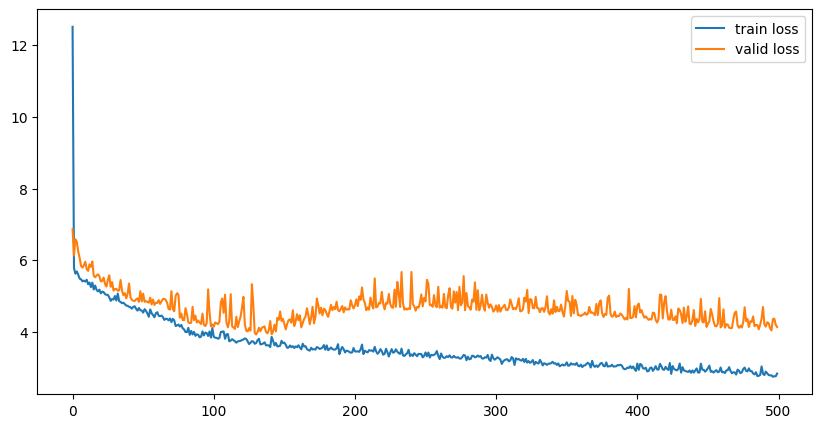

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(trainScores[0], label="train loss")
plt.plot(validScores[0], label="valid loss")
plt.legend()
plt.show()


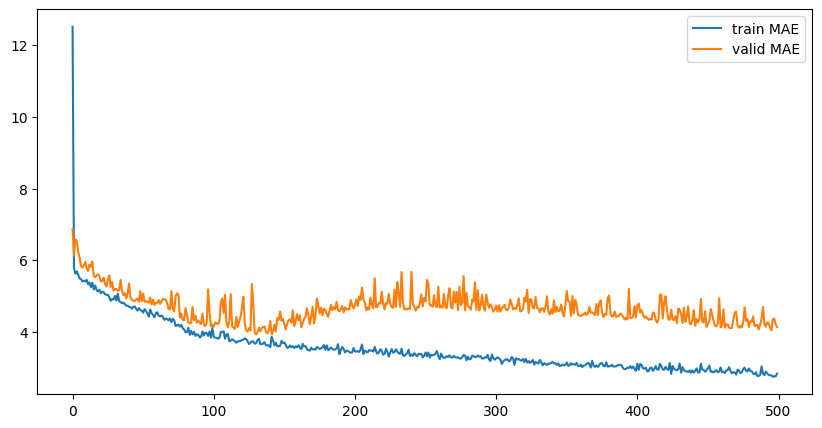

In [34]:
plt.figure(figsize=(10, 5))
plt.plot(trainScores[1], label="train MAE")
plt.plot(validScores[1], label="valid MAE")
plt.legend()
plt.show()


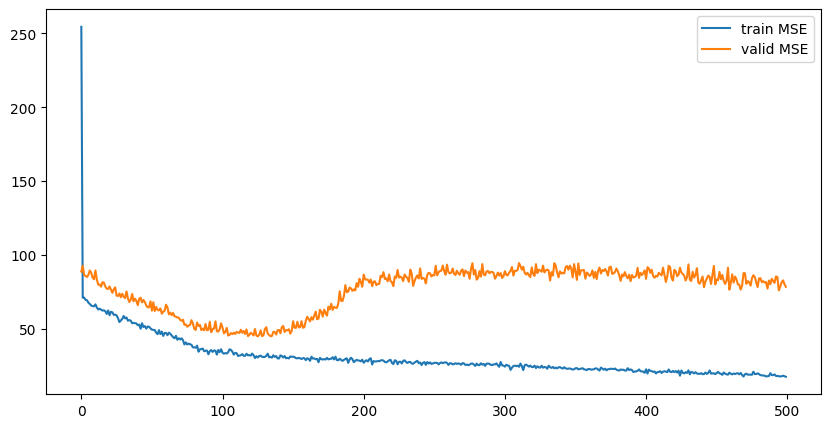

In [35]:
plt.figure(figsize=(10, 5))
plt.plot(trainScores[2], label="train MSE")
plt.plot(validScores[2], label="valid MSE")
plt.legend()
plt.show()


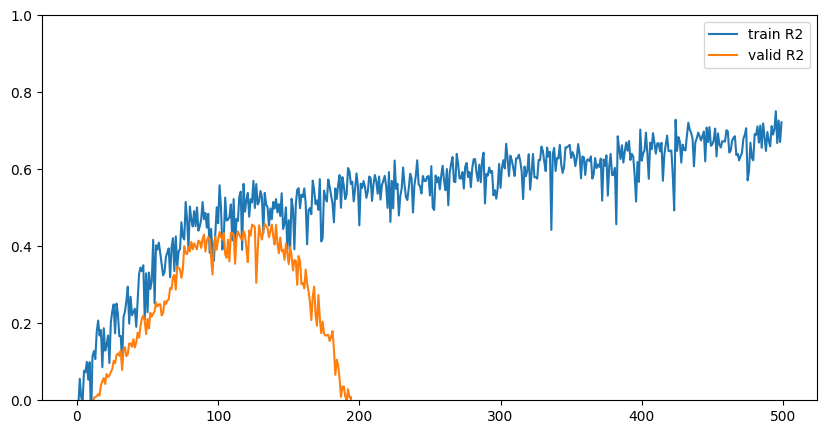

In [36]:
plt.figure(figsize=(10, 5))
plt.plot(trainScores[3], label="train R2")
plt.plot(validScores[3], label="valid R2")
plt.ylim(0, 1)
plt.legend()
plt.show()
